# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [642]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [643]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [644]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [645]:
def encoder_block(input_layer, filters, strides):
    
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [646]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
        
    # Concatenate the upsampled and large input layers using layers.concatenate
    
    #concat = layers.concatenate([small_conv, large_conv])
    concat = layers.concatenate([upsampled, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat, filters, 1)
    
    return output_layer

def decoder_block_lite(small_ip_layer, filters):
    upsampled = bilinear_upsample(small_ip_layer)
    output_layer = separable_conv2d_batchnorm(upsampled,filters,1)
    return output_layer


### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [647]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks
    l1 = encoder_block(inputs, 32, 2)
    l2 = encoder_block(l1, 128, 2)
    l2d = layers.Dropout(0.5)(l2)
    l3 = encoder_block(l2d, 512, 2)
    l3d = layers.Dropout(0.5)(l3)
    
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    l4 = conv2d_batchnorm(l3d, 1024, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    l5 = decoder_block(l4, l2, 256)
    l6 = decoder_block(l5, l1, 64)
    x = decoder_block(l6, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [648]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [649]:
learning_rate = 0.001
batch_size = 32
num_epochs = 100
#steps_per_epoch = 312  # 9987//32
#validation_steps = 79 # 2555//32
steps_per_epoch = 129  # 4131//32
validation_steps = 37 # 1184//32
workers = 2

Epoch 1/100
311/312 [============================>.] - ETA: 0s - loss: 0.4373

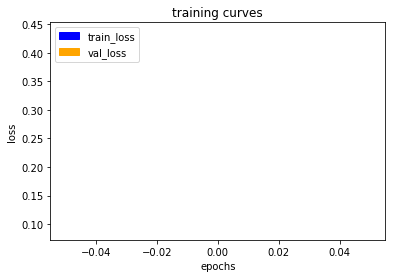

312/312 [==============================] - 160s - loss: 0.4361 - val_loss: 0.0898
Epoch 2/100
311/312 [============================>.] - ETA: 0s - loss: 0.0470

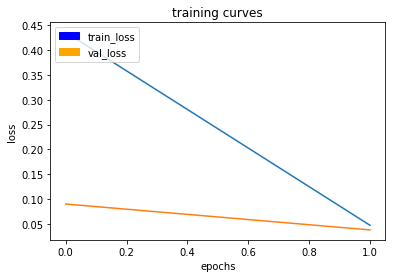

312/312 [==============================] - 157s - loss: 0.0470 - val_loss: 0.0376
Epoch 3/100
311/312 [============================>.] - ETA: 0s - loss: 0.0252

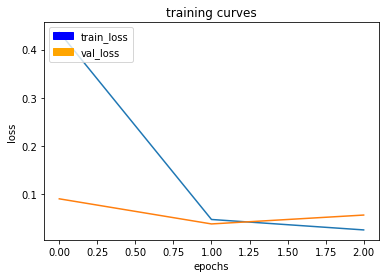

312/312 [==============================] - 158s - loss: 0.0252 - val_loss: 0.0561
Epoch 4/100
311/312 [============================>.] - ETA: 0s - loss: 0.0194

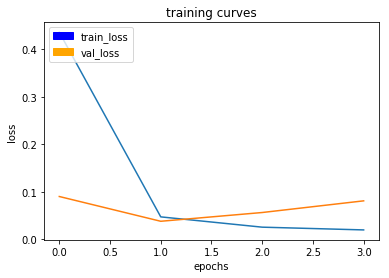

312/312 [==============================] - 157s - loss: 0.0194 - val_loss: 0.0807
Epoch 5/100
311/312 [============================>.] - ETA: 0s - loss: 0.0166

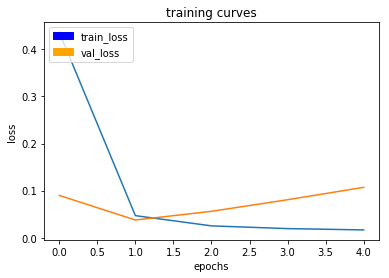

312/312 [==============================] - 157s - loss: 0.0166 - val_loss: 0.1070
Epoch 6/100
311/312 [============================>.] - ETA: 0s - loss: 0.0146

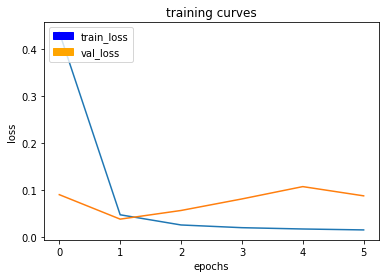

312/312 [==============================] - 157s - loss: 0.0146 - val_loss: 0.0873
Epoch 7/100
311/312 [============================>.] - ETA: 0s - loss: 0.0138

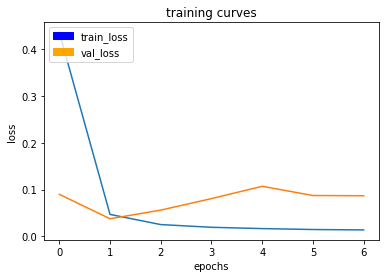

312/312 [==============================] - 157s - loss: 0.0138 - val_loss: 0.0868
Epoch 8/100
311/312 [============================>.] - ETA: 0s - loss: 0.0129

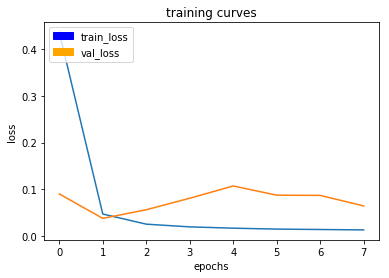

312/312 [==============================] - 157s - loss: 0.0129 - val_loss: 0.0642
Epoch 9/100
311/312 [============================>.] - ETA: 0s - loss: 0.0120

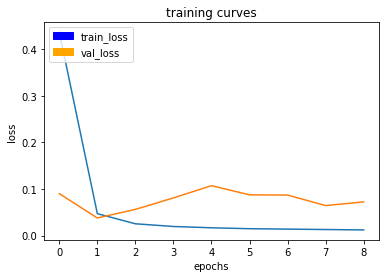

312/312 [==============================] - 157s - loss: 0.0120 - val_loss: 0.0721
Epoch 10/100
311/312 [============================>.] - ETA: 0s - loss: 0.0116

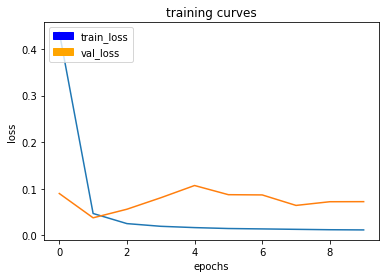

312/312 [==============================] - 158s - loss: 0.0116 - val_loss: 0.0723
Epoch 11/100
311/312 [============================>.] - ETA: 0s - loss: 0.0111

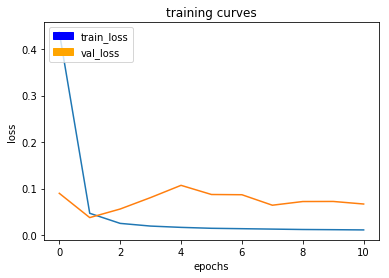

312/312 [==============================] - 158s - loss: 0.0111 - val_loss: 0.0668
Epoch 12/100
311/312 [============================>.] - ETA: 0s - loss: 0.0114

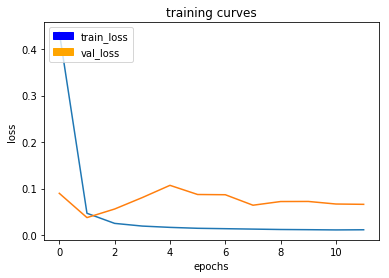

312/312 [==============================] - 157s - loss: 0.0114 - val_loss: 0.0661
Epoch 13/100
311/312 [============================>.] - ETA: 0s - loss: 0.0104

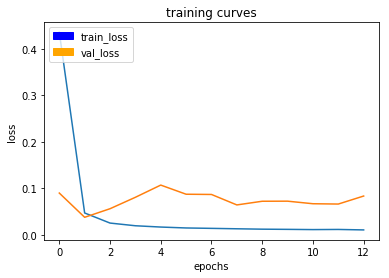

312/312 [==============================] - 158s - loss: 0.0105 - val_loss: 0.0834
Epoch 14/100
311/312 [============================>.] - ETA: 0s - loss: 0.0102

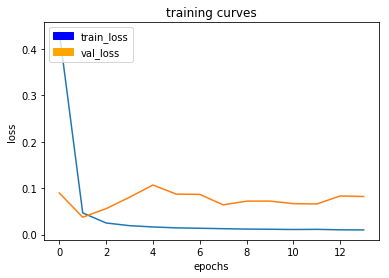

312/312 [==============================] - 158s - loss: 0.0102 - val_loss: 0.0822
Epoch 15/100
311/312 [============================>.] - ETA: 0s - loss: 0.0101

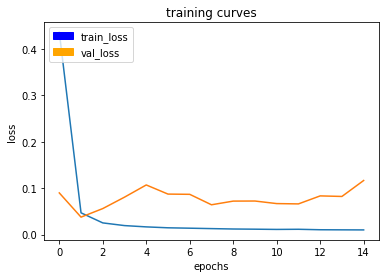

312/312 [==============================] - 157s - loss: 0.0101 - val_loss: 0.1166
Epoch 16/100
311/312 [============================>.] - ETA: 0s - loss: 0.0108

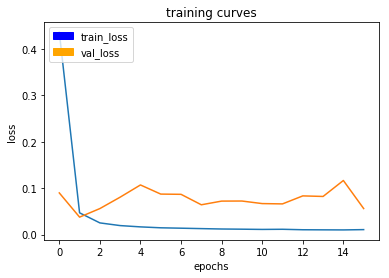

312/312 [==============================] - 157s - loss: 0.0108 - val_loss: 0.0561
Epoch 17/100
311/312 [============================>.] - ETA: 0s - loss: 0.0098

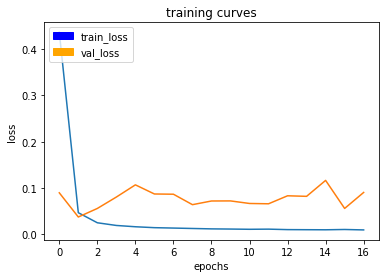

312/312 [==============================] - 157s - loss: 0.0098 - val_loss: 0.0906
Epoch 18/100
311/312 [============================>.] - ETA: 0s - loss: 0.0094

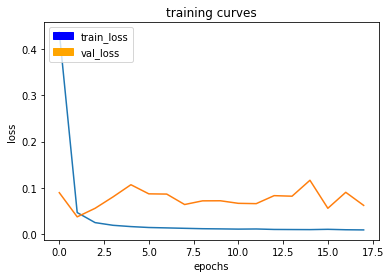

312/312 [==============================] - 158s - loss: 0.0094 - val_loss: 0.0623
Epoch 19/100
311/312 [============================>.] - ETA: 0s - loss: 0.0095

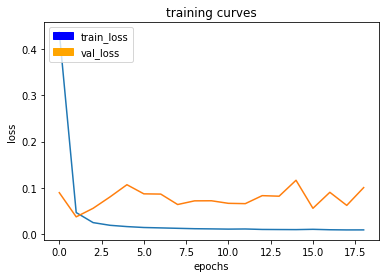

312/312 [==============================] - 158s - loss: 0.0095 - val_loss: 0.1007
Epoch 20/100
311/312 [============================>.] - ETA: 0s - loss: 0.0093

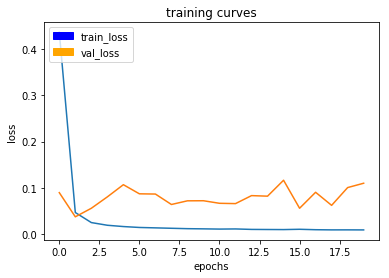

312/312 [==============================] - 157s - loss: 0.0093 - val_loss: 0.1101
Epoch 21/100
311/312 [============================>.] - ETA: 0s - loss: 0.0097

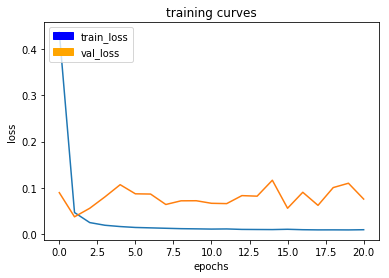

312/312 [==============================] - 157s - loss: 0.0097 - val_loss: 0.0759
Epoch 22/100
311/312 [============================>.] - ETA: 0s - loss: 0.0090

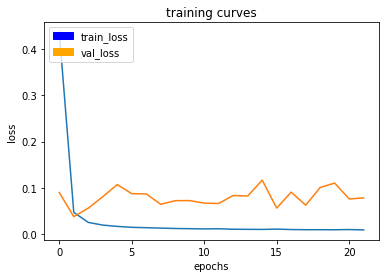

312/312 [==============================] - 158s - loss: 0.0090 - val_loss: 0.0781
Epoch 23/100
311/312 [============================>.] - ETA: 0s - loss: 0.0089

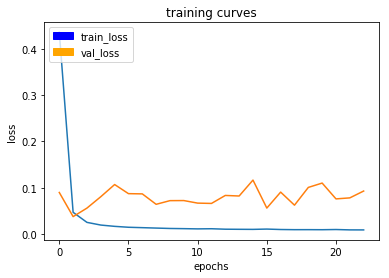

312/312 [==============================] - 157s - loss: 0.0089 - val_loss: 0.0929
Epoch 24/100
311/312 [============================>.] - ETA: 0s - loss: 0.0089

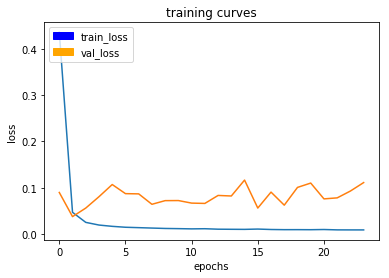

312/312 [==============================] - 157s - loss: 0.0089 - val_loss: 0.1112
Epoch 25/100
311/312 [============================>.] - ETA: 0s - loss: 0.0092

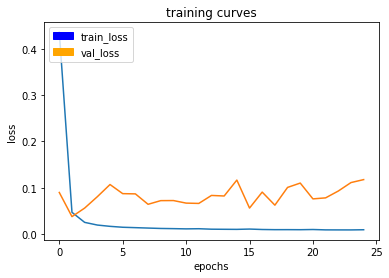

312/312 [==============================] - 157s - loss: 0.0092 - val_loss: 0.1176
Epoch 26/100
311/312 [============================>.] - ETA: 0s - loss: 0.0091

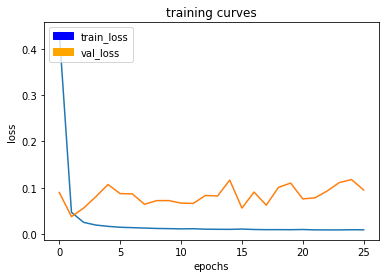

312/312 [==============================] - 158s - loss: 0.0091 - val_loss: 0.0952
Epoch 27/100
311/312 [============================>.] - ETA: 0s - loss: 0.0087

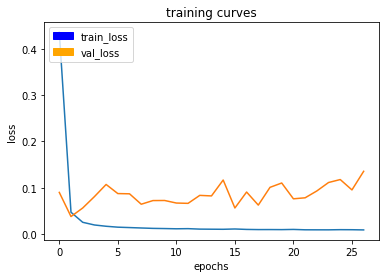

312/312 [==============================] - 158s - loss: 0.0087 - val_loss: 0.1354
Epoch 28/100
311/312 [============================>.] - ETA: 0s - loss: 0.0084

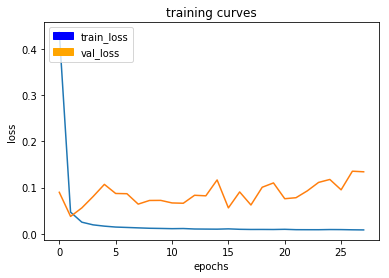

312/312 [==============================] - 157s - loss: 0.0084 - val_loss: 0.1342
Epoch 29/100
311/312 [============================>.] - ETA: 0s - loss: 0.0086

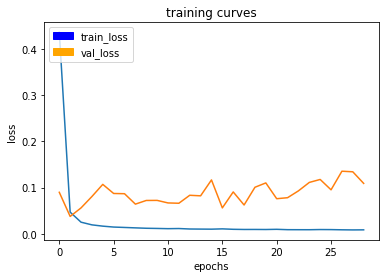

312/312 [==============================] - 157s - loss: 0.0086 - val_loss: 0.1091
Epoch 30/100
311/312 [============================>.] - ETA: 0s - loss: 0.0082

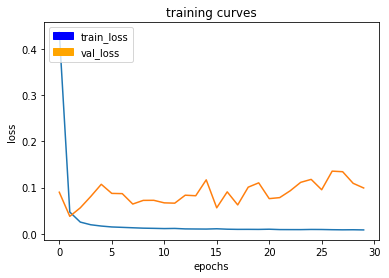

312/312 [==============================] - 157s - loss: 0.0082 - val_loss: 0.0990
Epoch 31/100
311/312 [============================>.] - ETA: 0s - loss: 0.0083

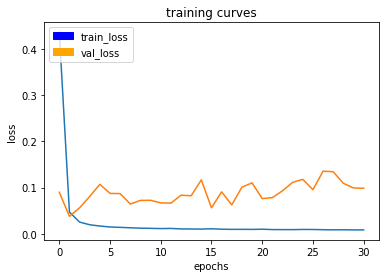

312/312 [==============================] - 157s - loss: 0.0083 - val_loss: 0.0984
Epoch 32/100
311/312 [============================>.] - ETA: 0s - loss: 0.0083

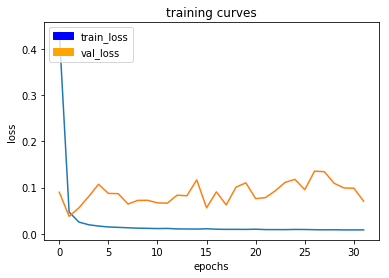

312/312 [==============================] - 157s - loss: 0.0083 - val_loss: 0.0705
Epoch 33/100
311/312 [============================>.] - ETA: 0s - loss: 0.0088

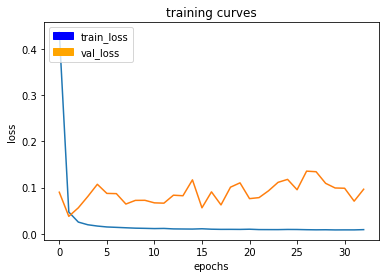

312/312 [==============================] - 157s - loss: 0.0088 - val_loss: 0.0963
Epoch 34/100
311/312 [============================>.] - ETA: 0s - loss: 0.0081

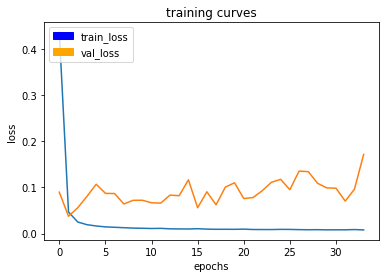

312/312 [==============================] - 157s - loss: 0.0081 - val_loss: 0.1715
Epoch 35/100
311/312 [============================>.] - ETA: 0s - loss: 0.0080

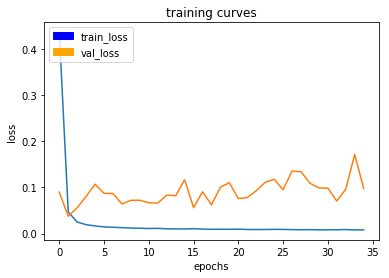

312/312 [==============================] - 157s - loss: 0.0080 - val_loss: 0.0979
Epoch 36/100
311/312 [============================>.] - ETA: 0s - loss: 0.0081

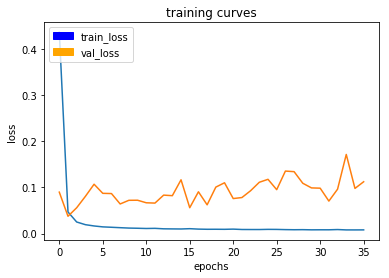

312/312 [==============================] - 157s - loss: 0.0081 - val_loss: 0.1123
Epoch 37/100
311/312 [============================>.] - ETA: 0s - loss: 0.0084

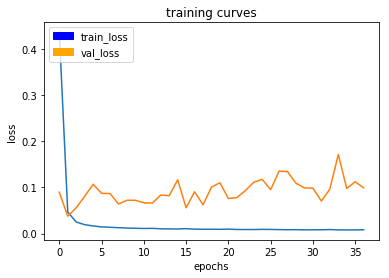

312/312 [==============================] - 157s - loss: 0.0084 - val_loss: 0.0990
Epoch 38/100
311/312 [============================>.] - ETA: 0s - loss: 0.0083

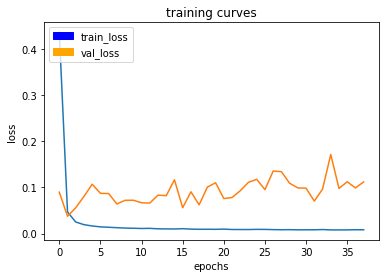

312/312 [==============================] - 157s - loss: 0.0083 - val_loss: 0.1120
Epoch 39/100
311/312 [============================>.] - ETA: 0s - loss: 0.0080

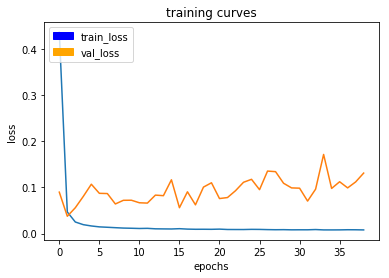

312/312 [==============================] - 157s - loss: 0.0080 - val_loss: 0.1311
Epoch 40/100
311/312 [============================>.] - ETA: 0s - loss: 0.0079

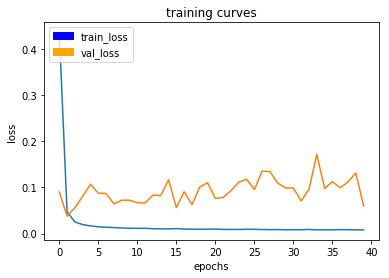

312/312 [==============================] - 157s - loss: 0.0079 - val_loss: 0.0597
Epoch 41/100
311/312 [============================>.] - ETA: 0s - loss: 0.0080

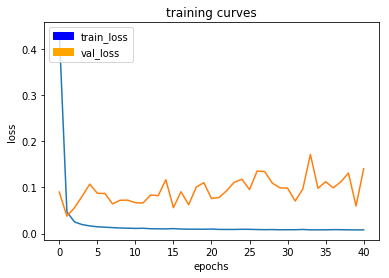

312/312 [==============================] - 157s - loss: 0.0080 - val_loss: 0.1403
Epoch 42/100
311/312 [============================>.] - ETA: 0s - loss: 0.0078

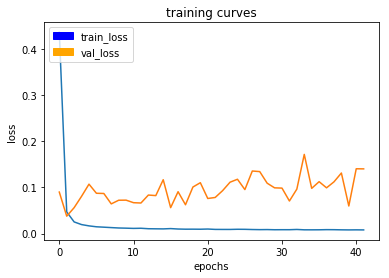

312/312 [==============================] - 157s - loss: 0.0078 - val_loss: 0.1401
Epoch 43/100
311/312 [============================>.] - ETA: 0s - loss: 0.0078

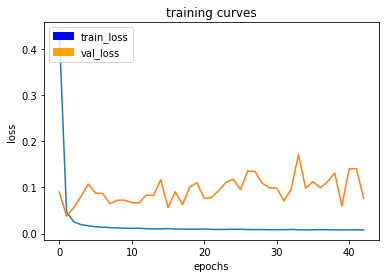

312/312 [==============================] - 157s - loss: 0.0078 - val_loss: 0.0765
Epoch 44/100
311/312 [============================>.] - ETA: 0s - loss: 0.0081

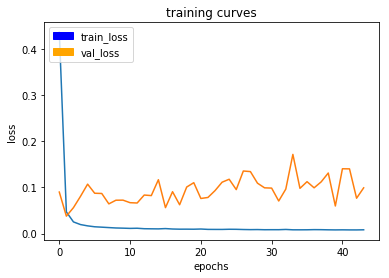

312/312 [==============================] - 157s - loss: 0.0081 - val_loss: 0.0990
Epoch 45/100
311/312 [============================>.] - ETA: 0s - loss: 0.0081

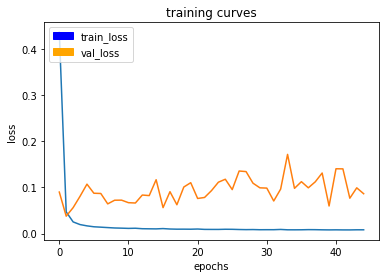

312/312 [==============================] - 157s - loss: 0.0081 - val_loss: 0.0862
Epoch 46/100
311/312 [============================>.] - ETA: 0s - loss: 0.0078

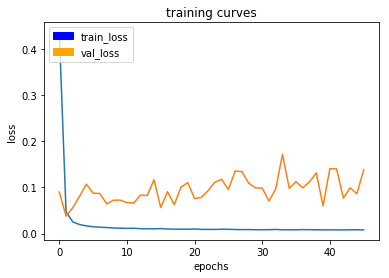

312/312 [==============================] - 157s - loss: 0.0078 - val_loss: 0.1378
Epoch 47/100
311/312 [============================>.] - ETA: 0s - loss: 0.0086

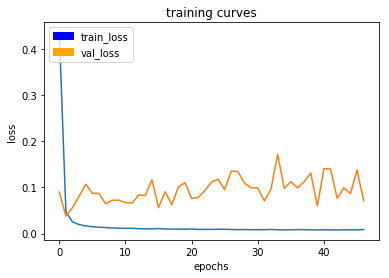

312/312 [==============================] - 157s - loss: 0.0086 - val_loss: 0.0707
Epoch 48/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

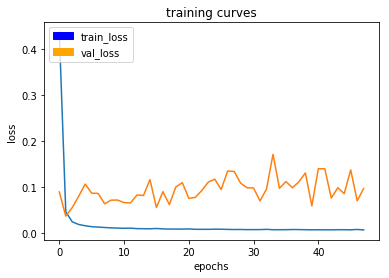

312/312 [==============================] - 157s - loss: 0.0076 - val_loss: 0.0974
Epoch 49/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

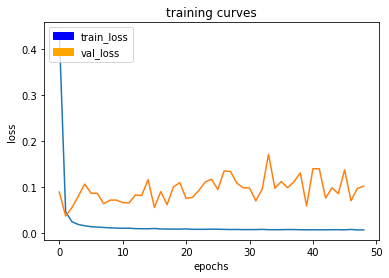

312/312 [==============================] - 157s - loss: 0.0076 - val_loss: 0.1025
Epoch 50/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

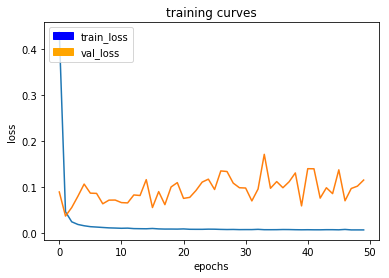

312/312 [==============================] - 158s - loss: 0.0076 - val_loss: 0.1157
Epoch 51/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

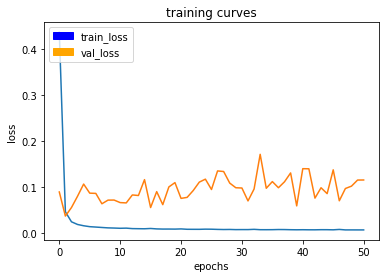

312/312 [==============================] - 157s - loss: 0.0076 - val_loss: 0.1158
Epoch 52/100
311/312 [============================>.] - ETA: 0s - loss: 0.0075

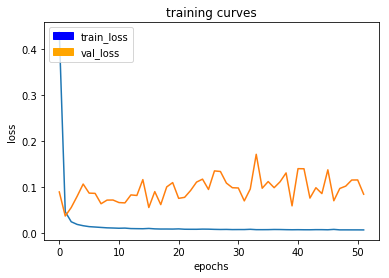

312/312 [==============================] - 157s - loss: 0.0075 - val_loss: 0.0849
Epoch 53/100
311/312 [============================>.] - ETA: 0s - loss: 0.0074

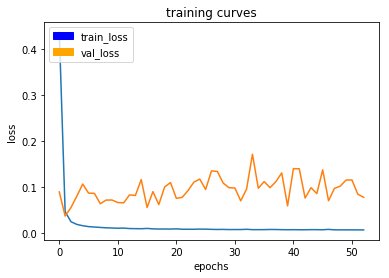

312/312 [==============================] - 157s - loss: 0.0074 - val_loss: 0.0781
Epoch 54/100
311/312 [============================>.] - ETA: 0s - loss: 0.0079

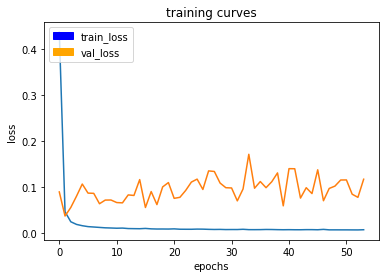

312/312 [==============================] - 157s - loss: 0.0079 - val_loss: 0.1173
Epoch 55/100
311/312 [============================>.] - ETA: 0s - loss: 0.0074

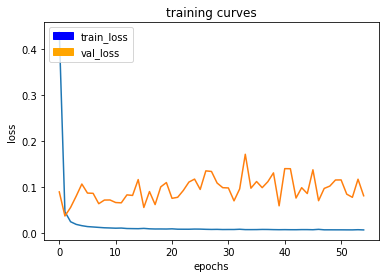

312/312 [==============================] - 157s - loss: 0.0074 - val_loss: 0.0815
Epoch 56/100
311/312 [============================>.] - ETA: 0s - loss: 0.0074

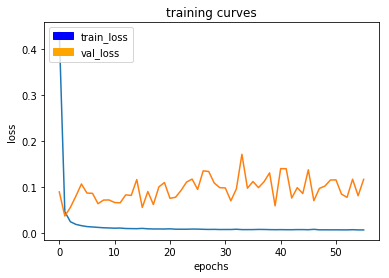

312/312 [==============================] - 157s - loss: 0.0074 - val_loss: 0.1170
Epoch 57/100
311/312 [============================>.] - ETA: 0s - loss: 0.0078

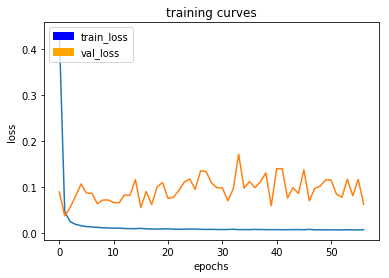

312/312 [==============================] - 157s - loss: 0.0078 - val_loss: 0.0627
Epoch 58/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

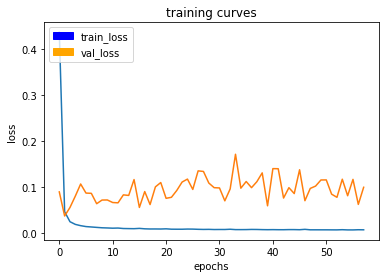

312/312 [==============================] - 157s - loss: 0.0076 - val_loss: 0.0998
Epoch 59/100
311/312 [============================>.] - ETA: 0s - loss: 0.0073

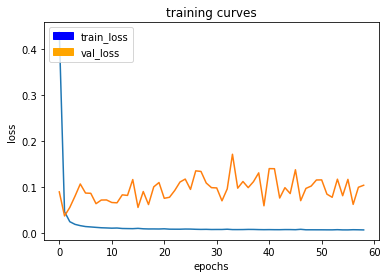

312/312 [==============================] - 157s - loss: 0.0073 - val_loss: 0.1042
Epoch 60/100
311/312 [============================>.] - ETA: 0s - loss: 0.0073

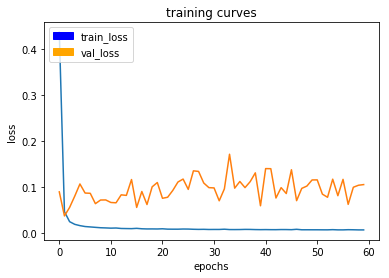

312/312 [==============================] - 157s - loss: 0.0073 - val_loss: 0.1056
Epoch 61/100
311/312 [============================>.] - ETA: 0s - loss: 0.0073

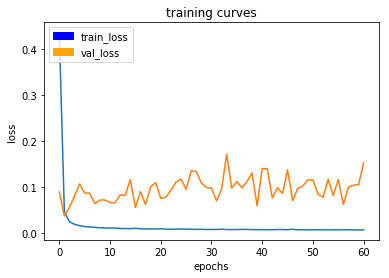

312/312 [==============================] - 157s - loss: 0.0073 - val_loss: 0.1531
Epoch 62/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

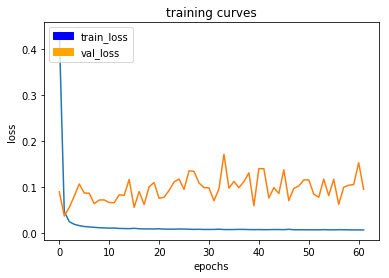

312/312 [==============================] - 157s - loss: 0.0073 - val_loss: 0.0953
Epoch 63/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

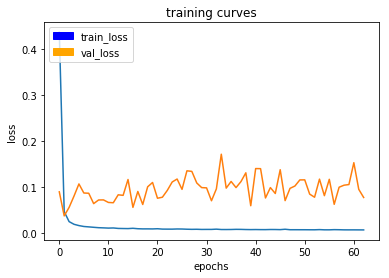

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.0776
Epoch 64/100
311/312 [============================>.] - ETA: 0s - loss: 0.0076

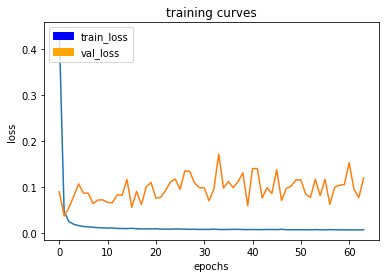

312/312 [==============================] - 157s - loss: 0.0076 - val_loss: 0.1198
Epoch 65/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

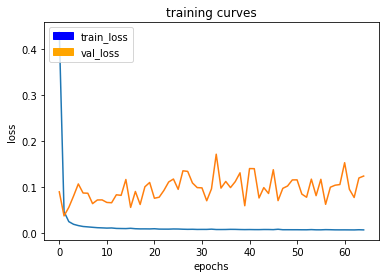

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.1241
Epoch 66/100
311/312 [============================>.] - ETA: 0s - loss: 0.0071

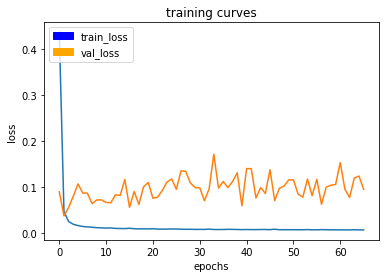

312/312 [==============================] - 157s - loss: 0.0071 - val_loss: 0.0952
Epoch 67/100
311/312 [============================>.] - ETA: 0s - loss: 0.0073

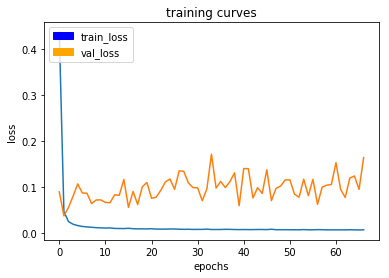

312/312 [==============================] - 158s - loss: 0.0073 - val_loss: 0.1641
Epoch 68/100
311/312 [============================>.] - ETA: 0s - loss: 0.0078

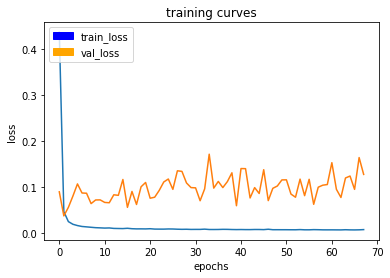

312/312 [==============================] - 157s - loss: 0.0078 - val_loss: 0.1276
Epoch 69/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

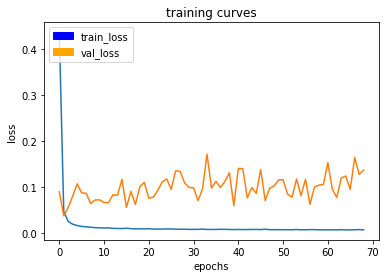

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1366
Epoch 70/100
311/312 [============================>.] - ETA: 0s - loss: 0.0071

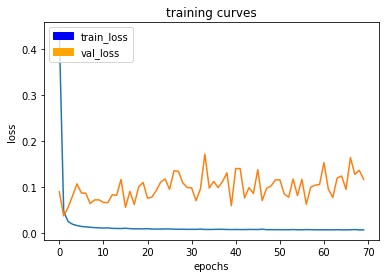

312/312 [==============================] - 157s - loss: 0.0071 - val_loss: 0.1166
Epoch 71/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

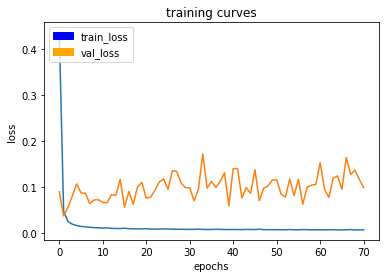

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.0992
Epoch 72/100
311/312 [============================>.] - ETA: 0s - loss: 0.0071

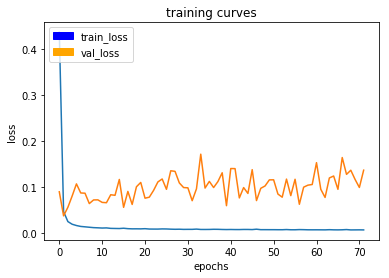

312/312 [==============================] - 157s - loss: 0.0071 - val_loss: 0.1367
Epoch 73/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

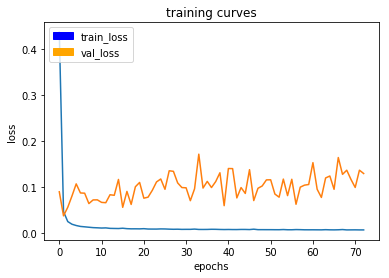

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1295
Epoch 74/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

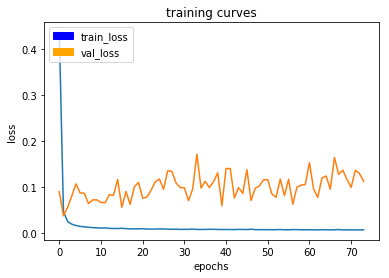

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.1126
Epoch 75/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

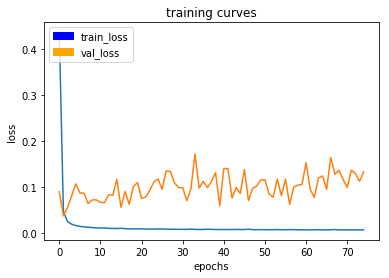

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1333
Epoch 76/100
311/312 [============================>.] - ETA: 0s - loss: 0.0077

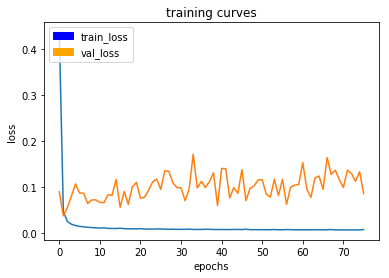

312/312 [==============================] - 157s - loss: 0.0077 - val_loss: 0.0860
Epoch 77/100
311/312 [============================>.] - ETA: 0s - loss: 0.0071

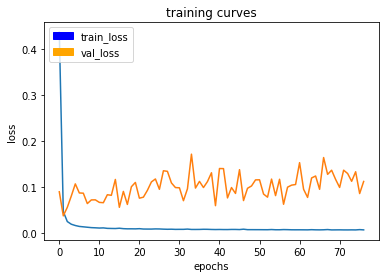

312/312 [==============================] - 157s - loss: 0.0071 - val_loss: 0.1122
Epoch 78/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

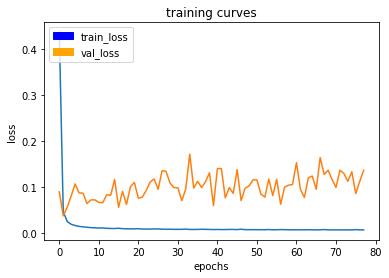

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1364
Epoch 79/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

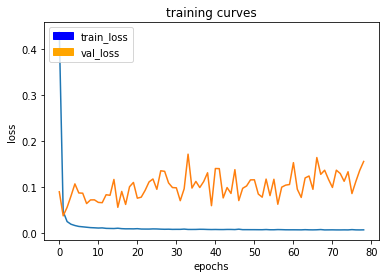

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.1556
Epoch 80/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

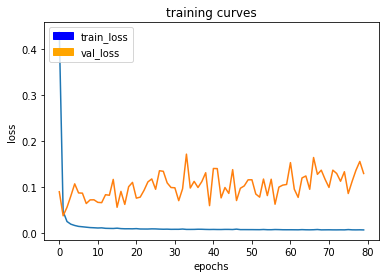

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1295
Epoch 81/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

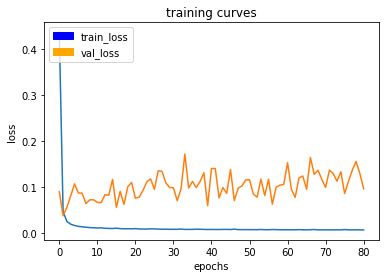

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.0963
Epoch 82/100
311/312 [============================>.] - ETA: 0s - loss: 0.0077

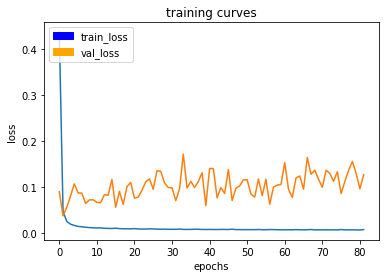

312/312 [==============================] - 157s - loss: 0.0077 - val_loss: 0.1265
Epoch 83/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

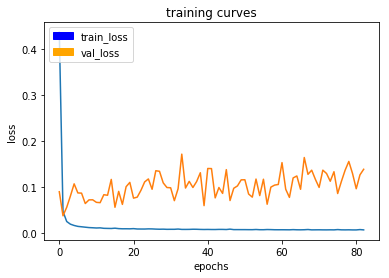

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1386
Epoch 84/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

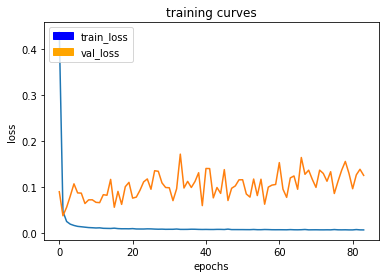

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1253
Epoch 85/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

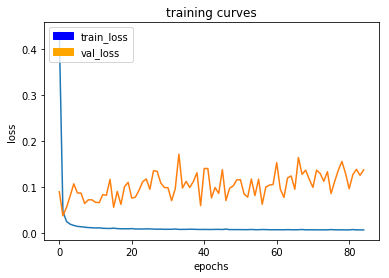

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1374
Epoch 86/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

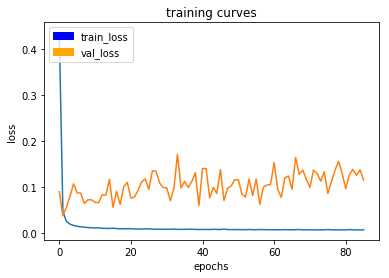

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1150
Epoch 87/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

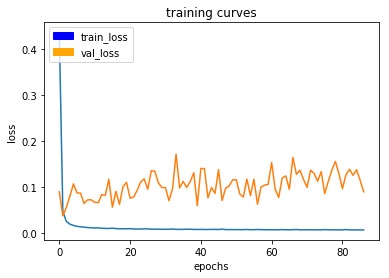

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.0897
Epoch 88/100
311/312 [============================>.] - ETA: 0s - loss: 0.0071

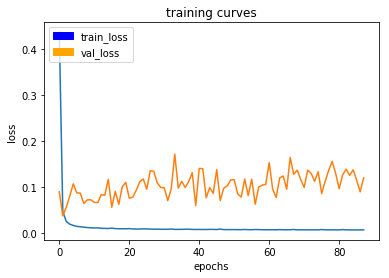

312/312 [==============================] - 157s - loss: 0.0071 - val_loss: 0.1198
Epoch 89/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

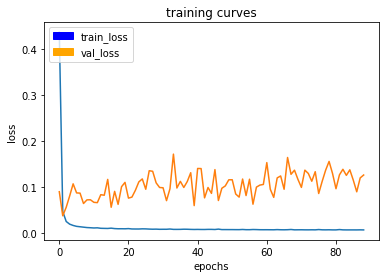

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1261
Epoch 90/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

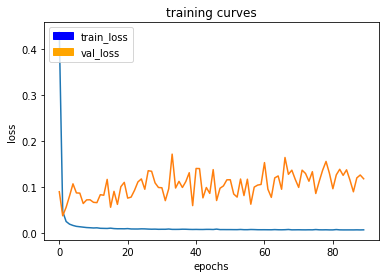

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1179
Epoch 91/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

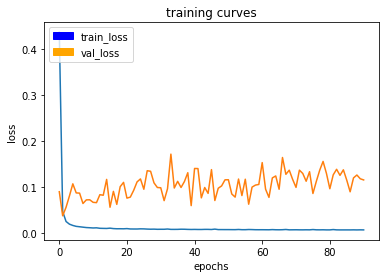

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1154
Epoch 92/100
311/312 [============================>.] - ETA: 0s - loss: 0.0070

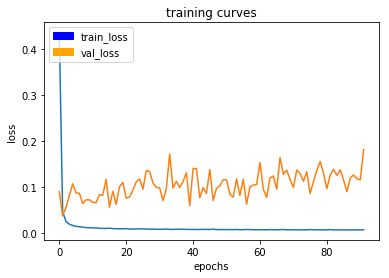

312/312 [==============================] - 157s - loss: 0.0070 - val_loss: 0.1810
Epoch 93/100
311/312 [============================>.] - ETA: 0s - loss: 0.0068

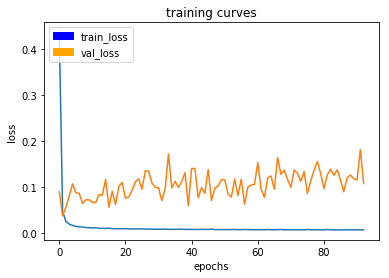

312/312 [==============================] - 157s - loss: 0.0068 - val_loss: 0.1077
Epoch 94/100
311/312 [============================>.] - ETA: 0s - loss: 0.0068

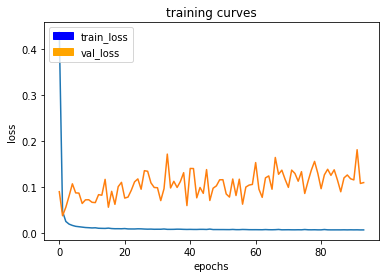

312/312 [==============================] - 157s - loss: 0.0068 - val_loss: 0.1096
Epoch 95/100
311/312 [============================>.] - ETA: 0s - loss: 0.0072

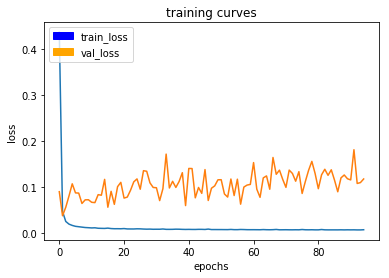

312/312 [==============================] - 157s - loss: 0.0072 - val_loss: 0.1174
Epoch 96/100
311/312 [============================>.] - ETA: 0s - loss: 0.0069

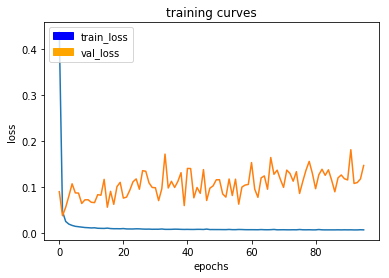

312/312 [==============================] - 157s - loss: 0.0069 - val_loss: 0.1467
Epoch 97/100
311/312 [============================>.] - ETA: 0s - loss: 0.0068

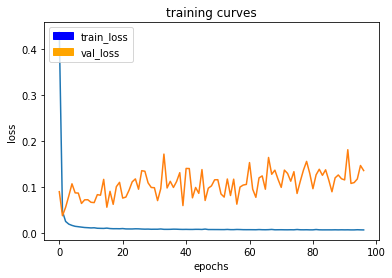

312/312 [==============================] - 157s - loss: 0.0068 - val_loss: 0.1357
Epoch 98/100
311/312 [============================>.] - ETA: 0s - loss: 0.0067

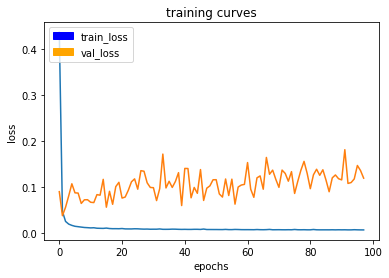

312/312 [==============================] - 157s - loss: 0.0067 - val_loss: 0.1192
Epoch 99/100
311/312 [============================>.] - ETA: 0s - loss: 0.0068

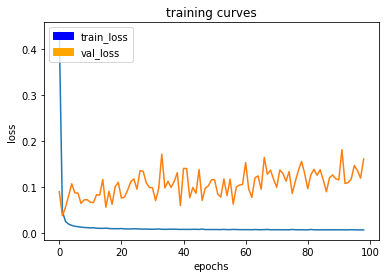

312/312 [==============================] - 157s - loss: 0.0068 - val_loss: 0.1608
Epoch 100/100
311/312 [============================>.] - ETA: 0s - loss: 0.0068

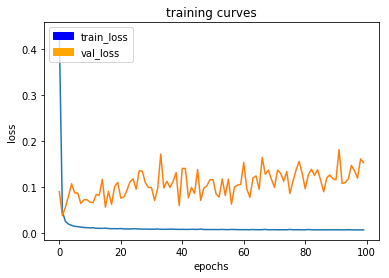

312/312 [==============================] - 157s - loss: 0.0068 - val_loss: 0.1527


In [650]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               #data_folder=os.path.join('..', 'data', 'processed_sim_data', 'train'),
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             #data_folder=os.path.join('..', 'data', 'processed_sim_data', 'validation'),
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [651]:
# Save your trained model weights
weight_file_name = 'model_weights.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [652]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [653]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

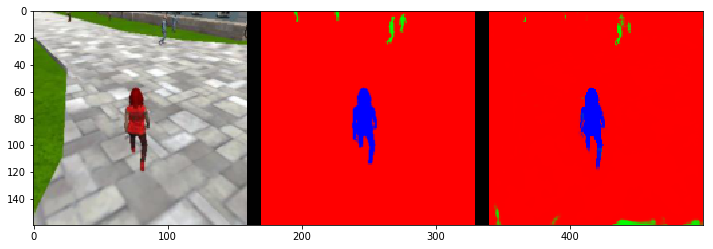

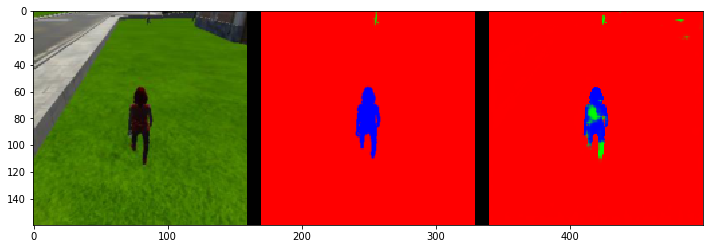

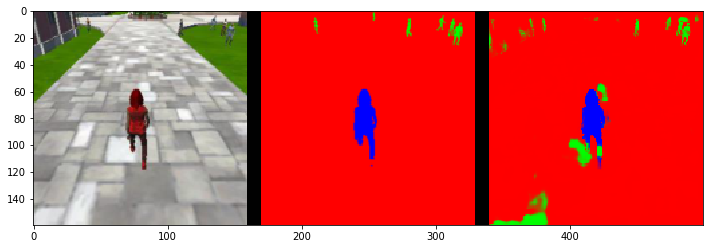

In [654]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

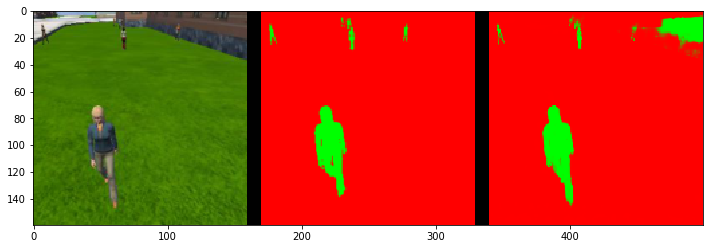

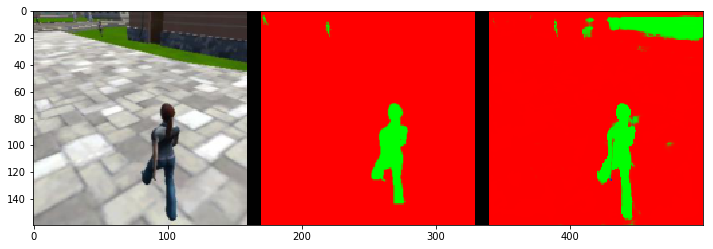

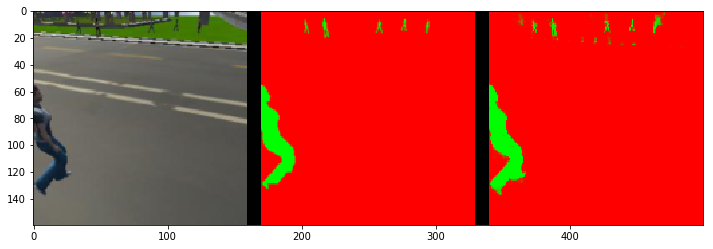

In [655]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

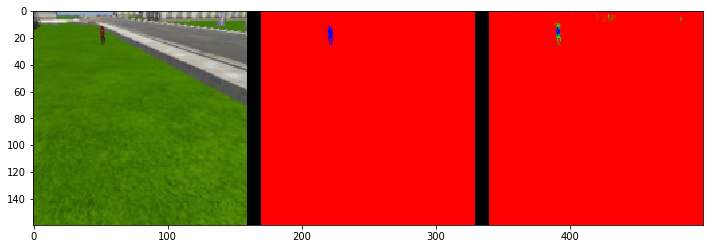

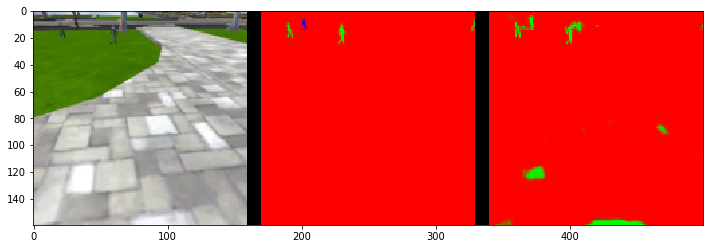

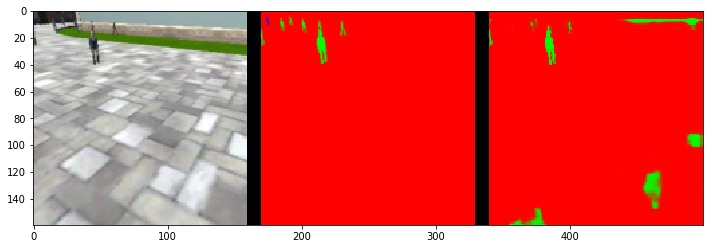

In [656]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [657]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9828234024766671
average intersection over union for other people is 0.20422049019561747
average intersection over union for the hero is 0.8842645698758579
number true positives: 539, number false positives: 0, number false negatives: 0


In [658]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9627678691127141
average intersection over union for other people is 0.616967971571984
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 50, number false negatives: 0


In [659]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9684150415466416
average intersection over union for other people is 0.20621846586136758
average intersection over union for the hero is 0.217237857981785
number true positives: 124, number false positives: 4, number false negatives: 177


In [660]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7416107382550335


In [661]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.550751213929


In [662]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.408443014357
